# Atmospheric retrieval on *real* data with Hamiltonian MCMC
### Multi-layer atmosphere with just a single species for now $O_2$
### Now with `numpyro`

Real A0V data from HPF!


May 2020

In [1]:
%%capture
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import time

import pandas as pd

In [2]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [3]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [4]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [5]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [6]:
@jit 
def ideal_gas_density(P_atm, T_K):
    '''Density from an ideal gas, return in cgs: number per cc'''
    P_pascals = P_atm * 101325.0 
    k_B = 1.380649e-23 
    density_num_per_meter_cubed = P_pascals / (k_B * T_K)
    return density_num_per_meter_cubed * 1.0e-6

In [7]:
@jit
def tau_of_T_p(T, p, nus, vol_mix_ratio, path_length_km, atomic_data):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    tau = abs_coeff * (vol_mix_ratio*ideal_gas_density(p, T)) * (path_length_km*100000.0)
    return tau

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')

## Get the atmospheric profile from TDAS  
Follow the prescription from Kevin Gullikson:
https://telfit.readthedocs.io/en/latest/GDAS_atmosphere.html

For now we'll use the average composition profiles from [the same source as TelFit](http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm)

In [10]:
import numpy as onp

In [11]:
#! wget http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm
#! mv ngt.atm ../data/

In [12]:
cols = ['HGT [km]','PRE [mb]','TEM [K]','N2 [ppmv]','O2 [ppmv]','CO2 [ppmv]','O3 [ppmv]',
        'H2O [ppmv]','CH4 [ppmv]','N2O [ppmv]','HNO3 [ppmv]','CO [ppmv]','NO2 [ppmv]',
        'N2O5 [ppmv]','ClO [ppmv]','HOCl [ppmv]','ClONO2 [ppmv]','NO [ppmv]','HNO4 [ppmv]',
        'HCN [ppmv]','NH3 [ppmv]','F11 [ppmv]','F12 [ppmv]','F14 [ppmv]','F22 [ppmv]',
        'CCl4 [ppmv]','COF2 [ppmv]','H2O2 [ppmv]','C2H2 [ppmv]','C2H6 [ppmv]','OCS [ppmv]',
        'SO2 [ppmv]','SF6 [ppmv]']

ngt_atm = pd.read_csv('../data/ngt.atm', comment='*', delim_whitespace=True, skiprows=25, names='ABCDE')
ngt_atm = pd.DataFrame(data=ngt_atm.stack().values.reshape(33, 121)).T
ngt_atm.columns = cols

In [13]:
ngt_atm['dens [cc]'] = onp.array(ideal_gas_density(ngt_atm['PRE [mb]'].values, ngt_atm['TEM [K]'].values))

/home/gully/GitHub/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [14]:
from sklearn.cluster import KMeans

In [15]:
ngt_atm = ngt_atm.loc[2:].reset_index()

In [16]:
X = onp.vstack([ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'].values]).T
X.shape

(119, 2)

In [17]:
n_layers = 15

In [18]:
kmeans = KMeans(n_clusters=n_layers).fit(X)

In [19]:
ngt_atm['path_length_km'] = 1.0

In [20]:
#ngt_atm['inds'] = kmeans.labels_
bins = onp.linspace(0, ngt_atm['dens [cc]'].max(), num=18)
inds = np.digitize(ngt_atm['dens [cc]'].values, bins)
print(onp.unique(inds).shape)
ngt_atm['inds'] = inds
aggregator = {col:onp.mean for col in ngt_atm.columns}
aggregator['path_length_km'] = onp.sum
bin_atm = ngt_atm.groupby('inds').agg(aggregator).sort_values('HGT [km]').reset_index(drop=True)

(15,)


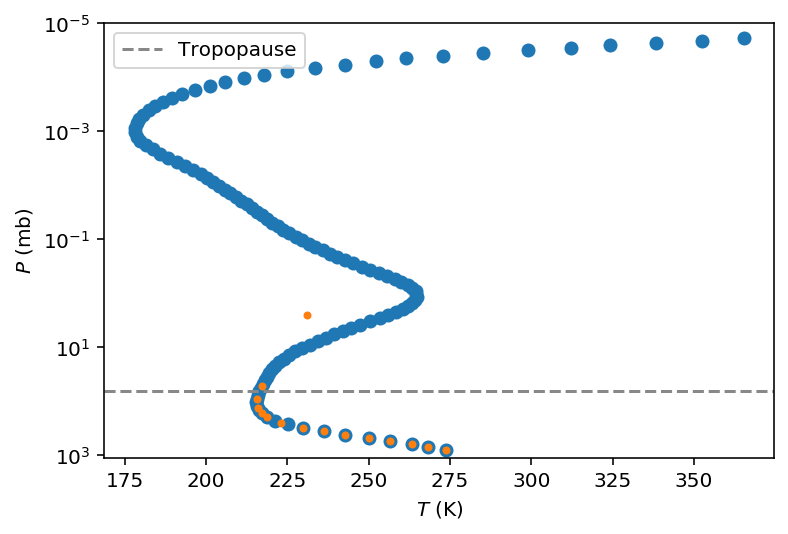

In [21]:
plt.plot(ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'],'o', label=None)
plt.plot(bin_atm['TEM [K]'].values, bin_atm['PRE [mb]'], '.',label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');

plt.legend();

What matters is the column density.

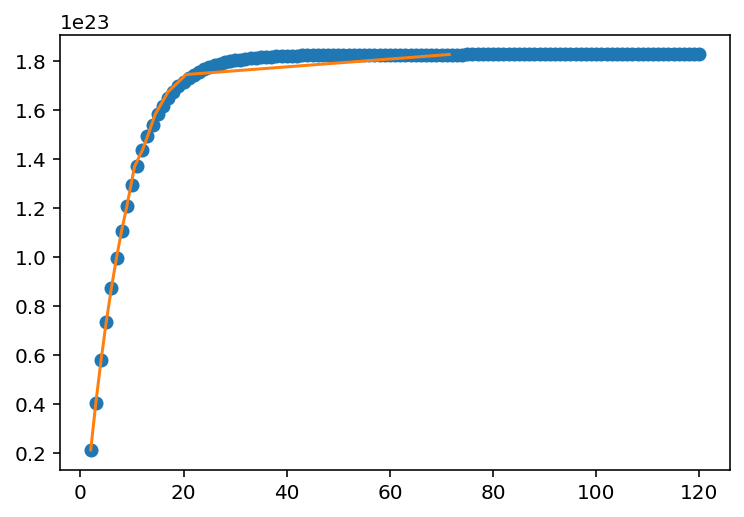

In [22]:
plt.plot(ngt_atm['HGT [km]'],(ngt_atm['dens [cc]']*ngt_atm['path_length_km']).cumsum(),  'o',label=None)
plt.plot(bin_atm['HGT [km]'],(bin_atm['dens [cc]']*bin_atm['path_length_km']).cumsum(),  '-',label=None)
#plt.ylim(2e23)

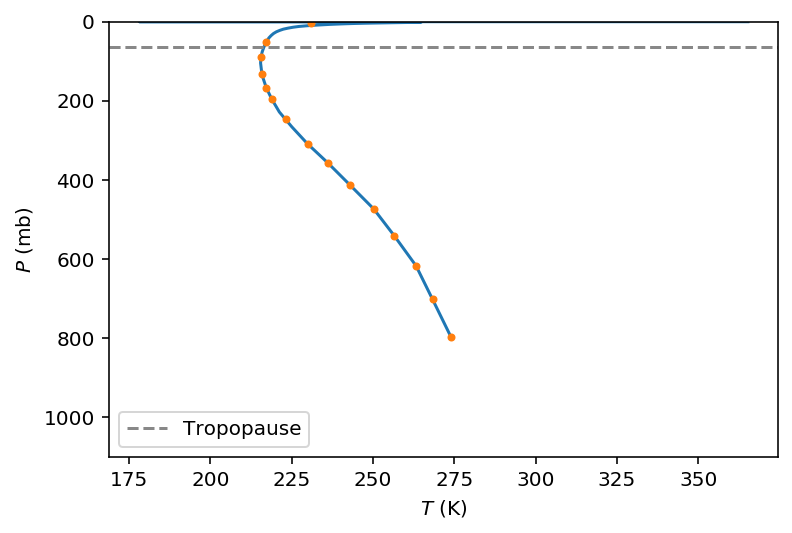

In [23]:
plt.plot(ngt_atm['TEM [K]'].values, ngt_atm['PRE [mb]'], label=None)
plt.plot(bin_atm['TEM [K]'].values, bin_atm['PRE [mb]'], '.',label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 0); plt.yscale('linear'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');

plt.legend();

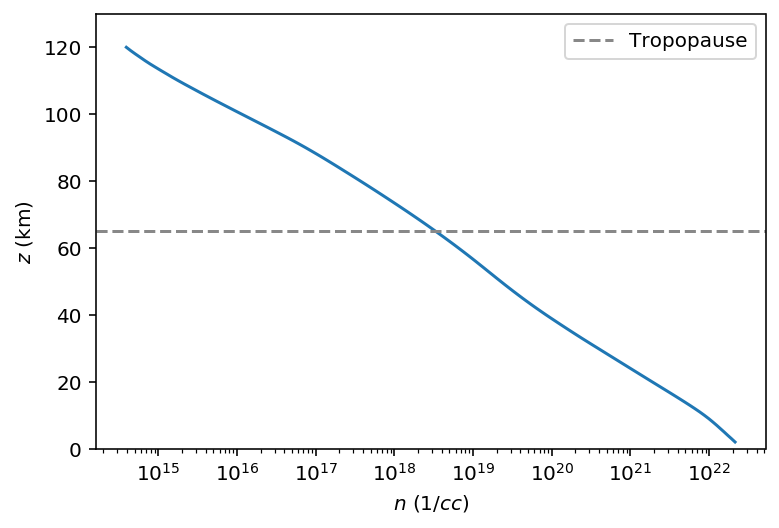

In [24]:
plt.plot(ngt_atm['dens [cc]'].values, ngt_atm['HGT [km]'], label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(0, 130); plt.xscale('log'); plt.ylabel('$z$ (km)'); plt.xlabel('$n$ ($1/cc$)');

#for temp in temp_control_points:
#    plt.axvline(temp, color='r')

plt.legend();

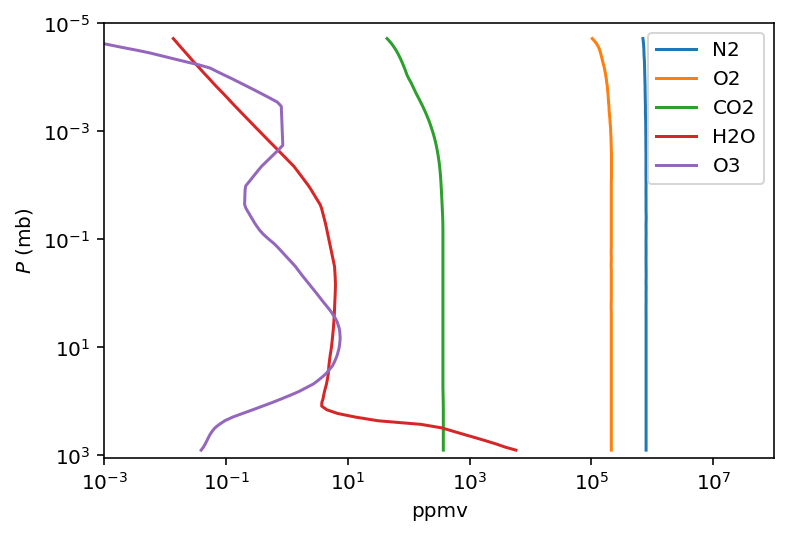

In [25]:
for species in ['N2', 'O2', 'CO2', 'H2O', 'O3']:
    plt.plot(ngt_atm[species+' [ppmv]'], ngt_atm['PRE [mb]'], label=species)
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('ppmv');
plt.xlim(1e-3, 1e8); plt.xscale('log'); plt.legend();

## Net transmission
The net $\tau$ is the sum of the optical depths.

In [26]:
@jit
def transmission_multilayer_atmosphere(T_vec, p_vec, vol_mix_ratio, path_length_km, airmass, nus, atomic_data=None):
    '''Compute transmission through a mutlilayer atmosphere'''
    
    net_tau = vmap(partial(tau_of_T_p, atomic_data=atomic_data),
                in_axes=(0,0,None,0,0)
                )(T_vec, P_vec, nus, path_length_km*airmass, vol_mix_ratio).sum(axis=0)
    return np.exp(-1.0*net_tau)

In [27]:
wls = np.linspace(12600, 12800, 20000)
nus = np.array((wls*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)
nus.shape

(20000,)

Rebin the atmosphere profile into nearly continuous steps.

In [28]:
T_vec, P_vec, height_vec, path_vec = (np.array(bin_atm['TEM [K]'].values), 
           np.array(bin_atm['PRE [mb]'].values/1013.25),
           np.array(bin_atm['HGT [km]'].values),
            np.array(bin_atm['path_length_km'].values))

Trim the linelist to the region of interest, with about 230 spectral lines.

In [29]:
O2_hitran_all = get_hapi_molec_data('O2')
mask = (O2_hitran_all[5] > nus.min()) & (O2_hitran_all[5] < nus.max())

In [30]:
O2_hitran = [arr[mask] for arr in O2_hitran_all]

In [31]:
O2_concentration_profile = np.array(bin_atm['O2 [ppmv]'].values*1.0e-6)

In [32]:
t0 = time.time()
O2_spectrum = transmission_multilayer_atmosphere(T_vec, P_vec, O2_concentration_profile, 
                                                 path_vec, 1.22, nus, 
                                          atomic_data=O2_hitran)

print(O2_spectrum[0], time.time() - t0)

0.9994134 1.0608692169189453


Now let's smooth it to the HPF resolution:

In [33]:
sig, mu = 8.5, 0.0
xx = np.linspace(-100, 100, 200)
slit_kernel = 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-mu)/sig)**2) 

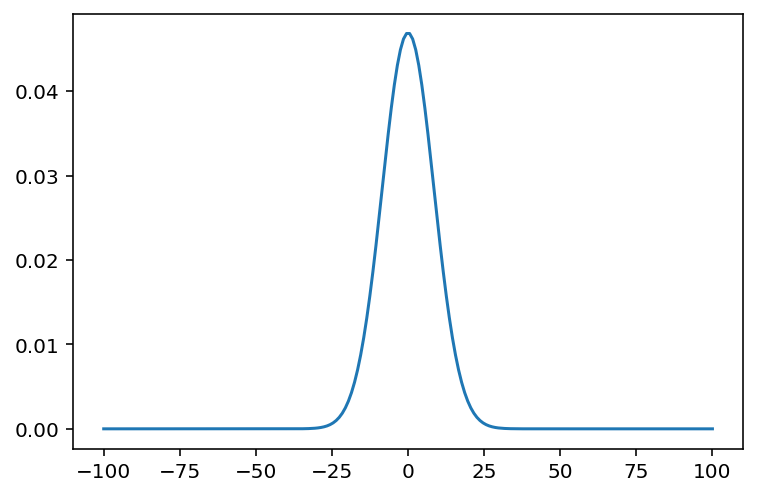

In [34]:
plt.plot(xx, slit_kernel)

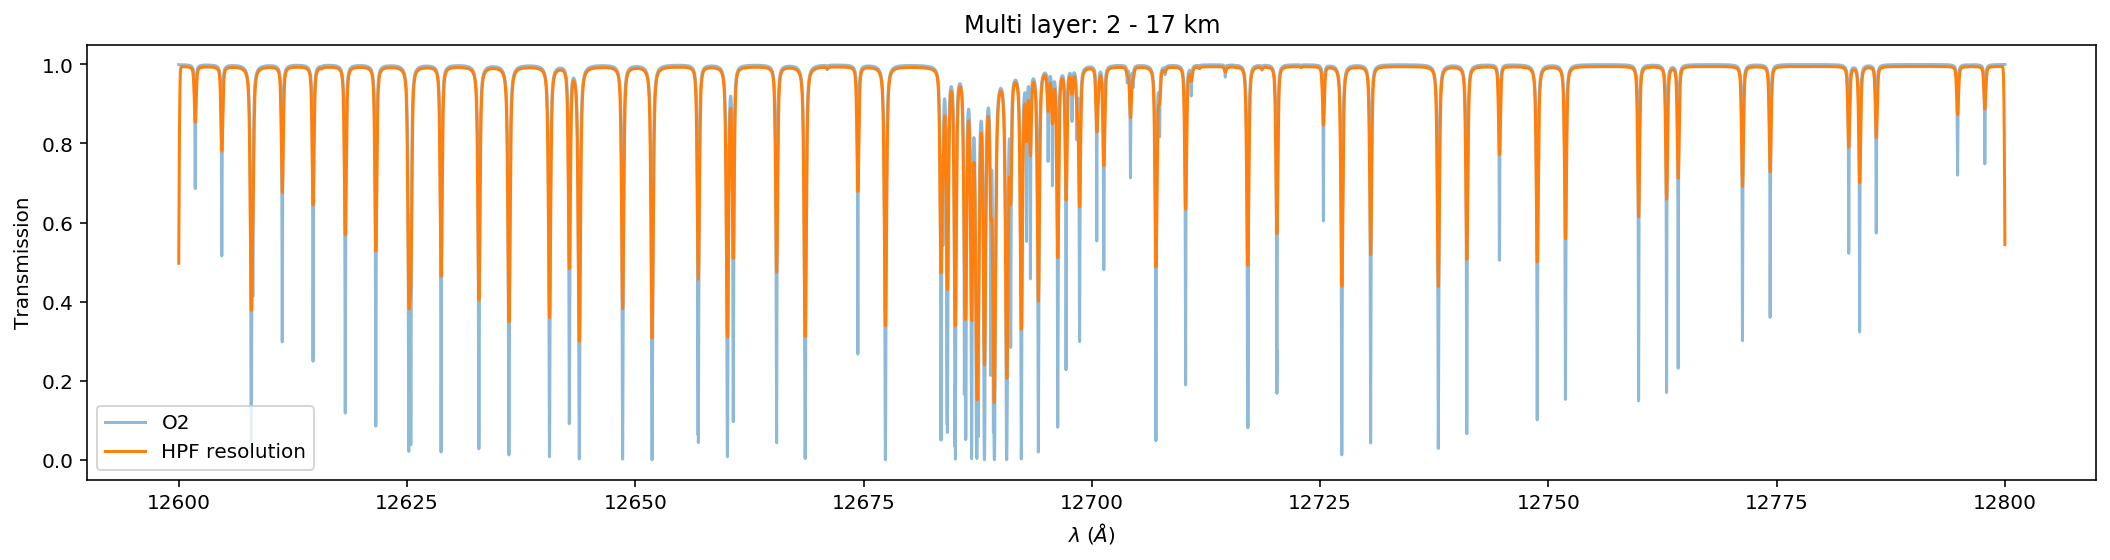

In [35]:
plt.figure(figsize=(18,4))
plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

## Get real HPF data

In [36]:
import numpy as onp
from astropy.io import fits
from astropy.table import Table

In [37]:
! ls /home/gully/GitHub/hopful/data/HPF/Dropbox/5-Vul

Slope-20190417T094236_R01_0040.optimal.fits
Slope-20190417T094621_R01_0041.optimal.fits
Slope-20190417T095007_R01_0042.optimal.fits


In [38]:
hdus = fits.open('../../hopful/data/HPF/Dropbox/5-Vul/Slope-20190417T094621_R01_0041.optimal.fits')

In [39]:
df_all = pd.DataFrame()
for m in range(28):
    tab = Table({hdus[i].name:hdus[i].data[m,:] for i in range(1,10)})
    tab['order'] = m
    df_all = df_all.append(tab.to_pandas(), ignore_index=True)

In [40]:
df_all = df_all[(df_all.order ==27) & (df_all['Sci Flux']==df_all['Sci Flux'])].reset_index(drop=True)

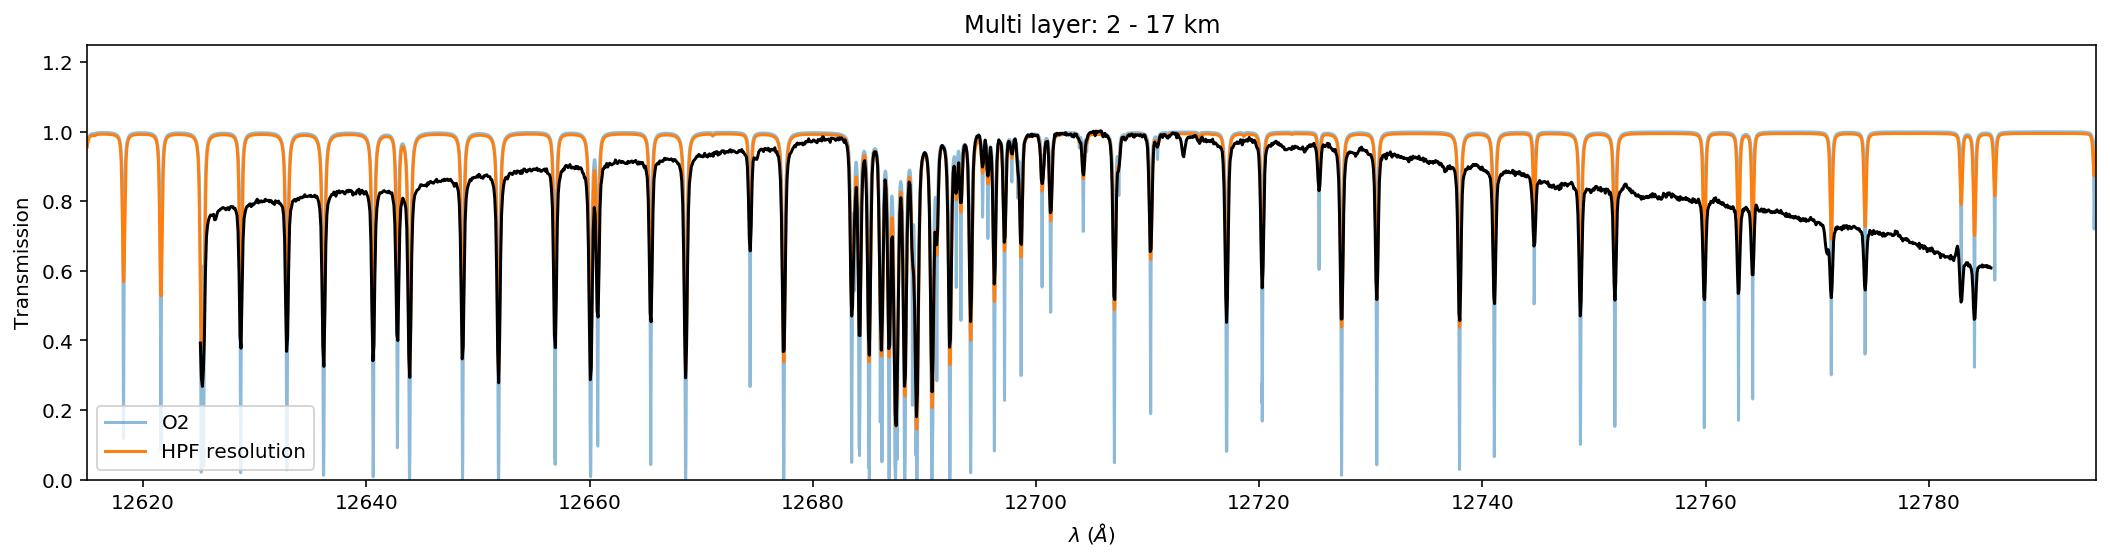

In [41]:
plt.figure(figsize=(18,4))

plt.plot(df_all['Sci Wavl'], df_all['Sci Flux']/onp.median(df_all['Sci Flux'])/1.18, color='k', zorder=10)

plt.plot(wls, O2_spectrum, label='O2', alpha=0.5)
plt.plot(wls, np.convolve(O2_spectrum, slit_kernel, mode='same'), label='HPF resolution')


plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

Ok, close to the HPF resolution!

## Pre-process the HPF data

Match raw wavelength gridpoints to the over-sampled model wavelengths.

In [42]:
obs_wl = np.array(df_all['Sci Wavl'].values)
nu_hpf = np.array((obs_wl*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)
inds = np.array(np.digitize(wls, obs_wl)) 

Scale the flux to a max of 1.0

In [43]:
scalar_normalization = onp.percentile(df_all['Sci Flux'], 98)
obs_flux = np.array(df_all['Sci Flux'].values/scalar_normalization)

Rescale the uncertainty.

In [44]:
sigma_noise = np.float32(onp.median(onp.sqrt(df_all['Sci Variance'].values)/scalar_normalization))
sigma_noise

DeviceArray(0.00294035, dtype=float32)

Wow, it's $S/N=300$!

### Forward model the blaze shape with polynomials
Eventually we could use Chebyshev Polynomials

In [45]:
a_guess = -0.29
b_guess = -0.03
c_guess = 1.0
vec = (wls-12700.0)/80
blaze_guess = a_guess*vec**2 + b_guess*vec + c_guess

In [46]:
hdr = hdus[0].header

In [47]:
zenith_angle = hdr['ZA']

In [48]:
airmass_est = 1.0/np.cos(np.radians(zenith_angle))

In [49]:
airmass_est

DeviceArray(1.22041, dtype=float32)

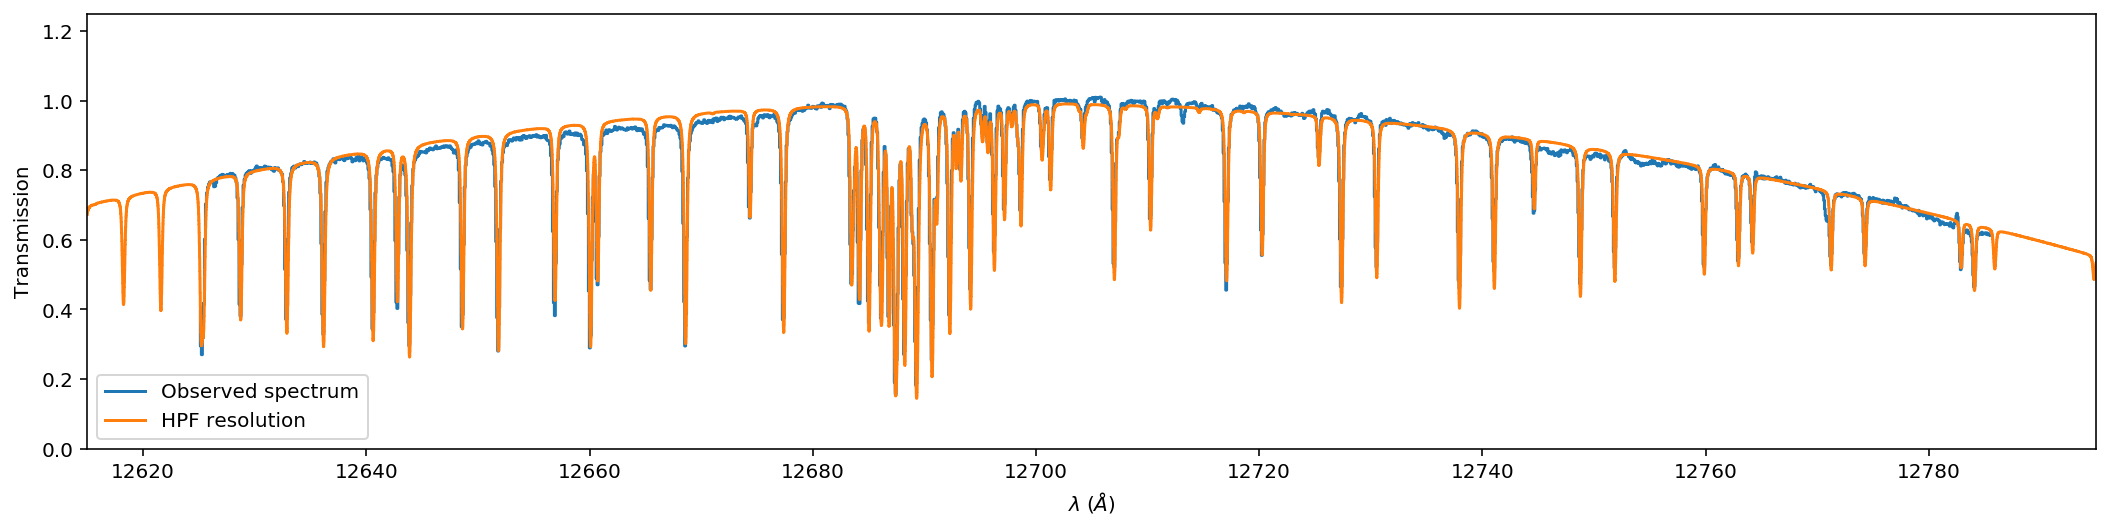

In [50]:
plt.figure(figsize=(18,4))
plt.step(obs_wl, obs_flux, label='Observed spectrum')

plt.step(wls, np.convolve(O2_spectrum, slit_kernel, mode='same')*blaze_guess, label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

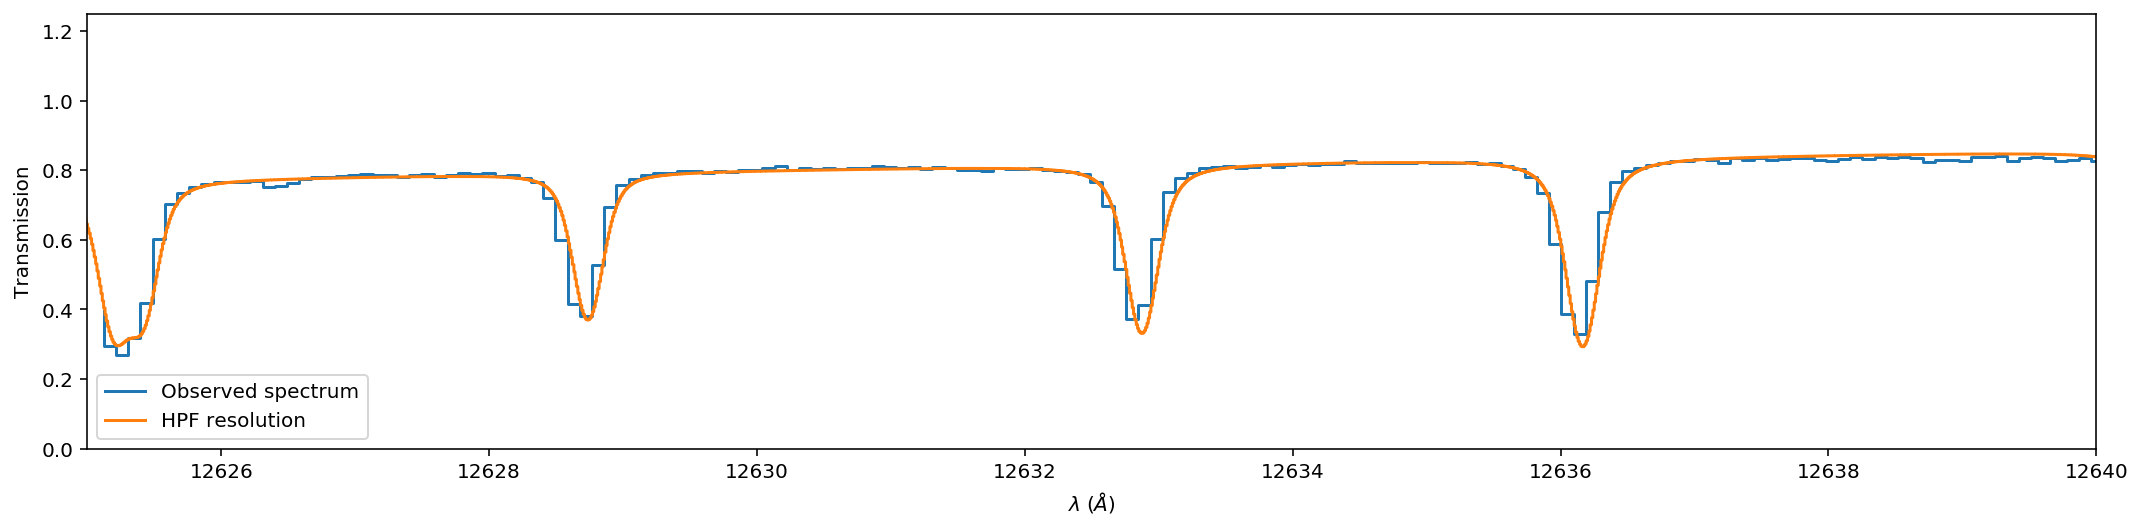

In [51]:
plt.figure(figsize=(18,4))
plt.step(obs_wl, obs_flux, label='Observed spectrum')

plt.step(wls, np.convolve(O2_spectrum, slit_kernel, mode='same')*blaze_guess, label='HPF resolution')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12625, 12640); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

In [52]:
xx = np.linspace(-100, 100, 200)

In [53]:
@jit
def mean_model_func(T_input, psf_width, delta_lam):
    '''Return the rebinned spectrum, uses global arrays for now'''
    noise_free_spectrum_native = transmission_multilayer_atmosphere(T_input, P_vec, 
                                                                    O2_concentration_profile, path_vec, 1.22041, nus, 
                                                                    atomic_data=O2_hitran)
    
    slit_kernel = 1/(psf_width*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-delta_lam)/psf_width)**2) 
    noise_free_spectrum_high_sampling = np.convolve(noise_free_spectrum_native, slit_kernel, mode='same')
    # `inds` below is a Global.  Is that OKAY??
    rebinned_spectrum = np.array([noise_free_spectrum_high_sampling[inds == i].mean() for i in range(2040)])
    return rebinned_spectrum

## Hamiltonian MCMC with numpyro

In [54]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

`vec` will remain a global here for now

In [55]:
vec = (obs_wl-12700.0)/80

In [56]:
obs_flux.shape, vec.shape

((2040,), (2040,))

In [67]:
def model():
    sigma_Ts = 55.1*np.ones(15)
    T_profs = numpyro.sample("T", dist.Normal(T_vec, sigma_Ts))
    #P_profs = numpyro.sample("P", dist.Normal(P_init, 0.02*np.ones(15)))
    #sigma = numpyro.sample("sigma", dist.Uniform(10.0, 11.0))
    
    psf_width = numpyro.sample("w", dist.Normal(8.5, 3.0))
    delta_lam = numpyro.sample("dl", dist.Normal(0.0, 8.0))
    aa = numpyro.sample("a", dist.Normal(-0.29, 2.0))
    bb = numpyro.sample("b", dist.Normal(-0.03, 1.0))
    cc = numpyro.sample("c", dist.Normal(1.0, 2.0))
    mean_blaze = aa * vec**2 + bb * vec + cc
    
    mean_model = mean_model_func(T_profs, psf_width, delta_lam)*mean_blaze
    numpyro.sample("obs", dist.Normal(mean_model, 0.003*np.ones(2040)), obs=obs_flux)

In [68]:
rng = random.PRNGKey(0)
rng, rng_ = random.split(rng)

# Run NUTS.
kernel = NUTS(model)

In [69]:
num_warmup, num_samples = 100, 1000

In [70]:
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=1)#, 
            #progress_bar=True, jit_model_args=True, chain_method='vectorized')

In [71]:
mcmc.run(rng_, init_params={'T':T_vec, 'a':-0.29, 'b':-0.03,'c':1.0, 'w':8.5, 'dl':0.0})

sample: 100%|██████████| 1100/1100 [23:34<00:00,  1.29s/it, 1 steps of size 1.18e-38. acc. prob=0.00]   


It took 3h45m to do 1677 samples.  Let's cut it off.

In [72]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      T[0]    273.91      0.00    273.91    273.91    273.91      0.50      1.00
      T[1]    268.30      0.00    268.30    268.30    268.30      0.50      1.00
      T[2]    263.24      0.00    263.24    263.24    263.24      0.50      1.00
      T[3]    256.55      0.00    256.55    256.55    256.55      0.50      1.00
      T[4]    250.20      0.00    250.20    250.20    250.20      0.50      1.00
      T[5]    242.82      0.00    242.82    242.82    242.82      0.50      1.00
      T[6]    236.17      0.00    236.17    236.17    236.17      0.50      1.00
      T[7]    229.87      0.00    229.87    229.87    229.87      0.50      1.00
      T[8]    223.11      0.00    223.12    223.12    223.12      0.50      1.00
      T[9]    218.85      0.00    218.85    218.85    218.85      0.50      1.00
     T[10]    217.19      0.00    217.19    217.19    217.19      0.50      1.00
     T[11]    215.94      0

In [73]:
samples = mcmc.get_samples(group_by_chain=False)

In [74]:
samples['T'].shape

(1000, 15)

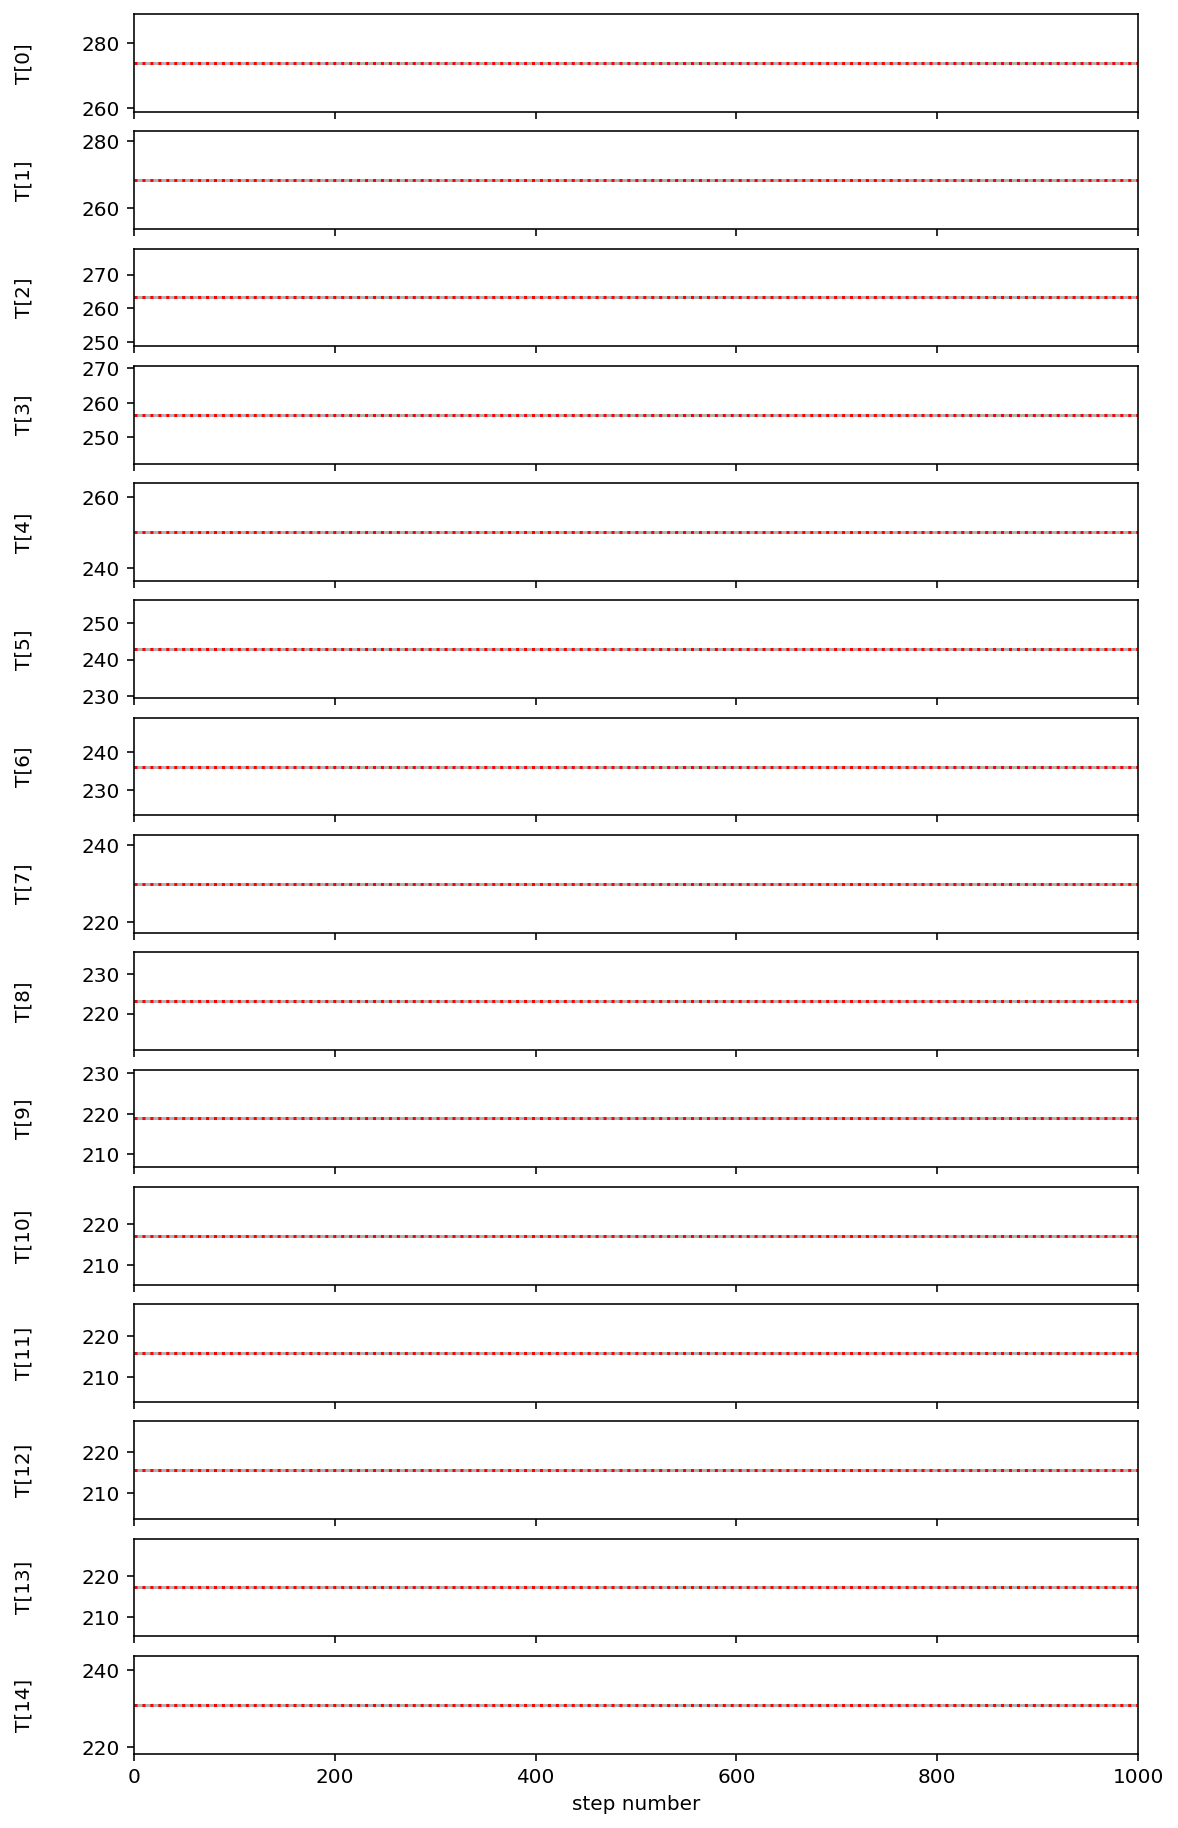

In [75]:
fig, axes = plt.subplots(15, figsize=(9, 16), sharex=True)
samples = mcmc.get_samples(group_by_chain=False)
for i in range(15):
    ax = axes[i]
    ax.plot(samples['T'][:,i], "k", alpha=0.3)
    ax.set_xlim(0, num_samples)
    ax.axhline(T_vec[i], color='r', linestyle='dotted')
    ax.set_ylabel('T[{}]'.format(i))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

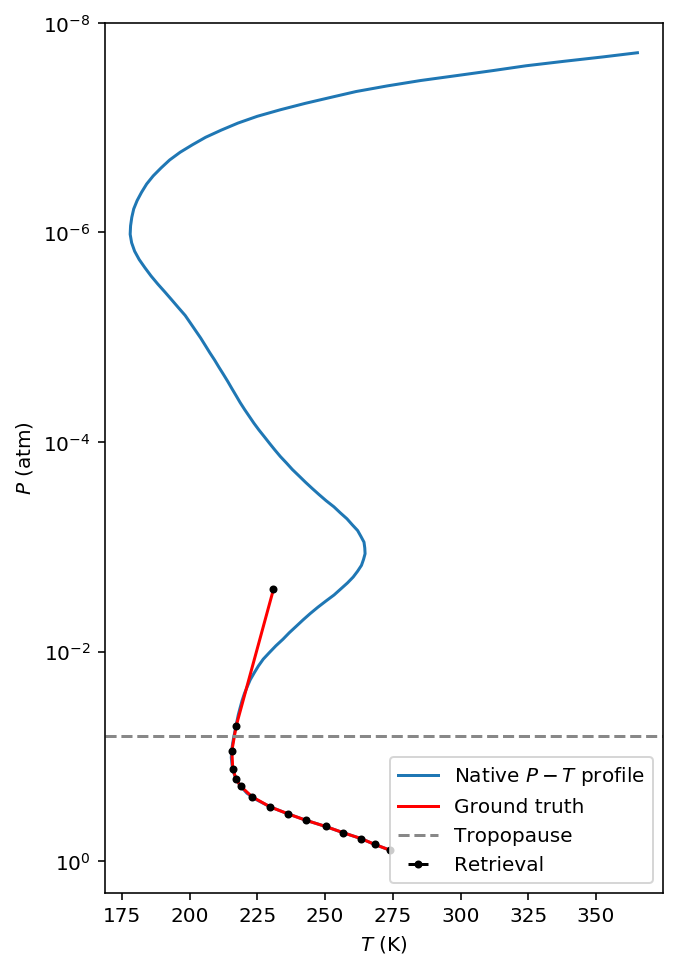

In [76]:
plt.figure(figsize=(5,8))
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]']/1013.25, label='Native $P-T$ profile')
plt.errorbar(samples['T'][150:, :].mean(axis=0), P_vec, xerr=samples['T'].std(axis=0), ecolor='k', 
             fmt='.', color='k', label='Retrieval')
plt.plot(T_vec, P_vec, color='r', label='Ground truth')

plt.axhline(ngt_atm.loc[17, 'PRE [mb]']/1013.25, linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(2, 1e-8); plt.yscale('log'); plt.ylabel('$P$ (atm)'); plt.xlabel('$T$ (K)');
plt.legend();
plt.yscale('log')

Awesome! The uncertainty increases as you go up in the atmosphere because the density decreases, and so the total column of opacity in a fixed 1 km layer becomes increasingly insignificant to the total absorption.  We could elect to sample the atmosphere in logarithmic bins, but then we lose the ability to see kinks in the atmosphere like the tropopause.  

In [ ]:
mean_model_func(T_vec, 8.5, 0.0)

In [77]:
posterior_draw = mean_model_func(samples['T'][289, :])

TypeError: mean_model_func() missing 2 required positional arguments: 'psf_width' and 'delta_lam'

In [ ]:
a_post = samples['a'][289]
b_post = samples['b'][289]
c_post = samples['c'][289]
vec = (obs_wl-12700.0)/80
blaze_draw = a_post*vec**2 + b_post*vec + c_post

In [ ]:
plt.figure(figsize=(18,4))
plt.plot(obs_wl, obs_flux, label='Observed spectrum')

plt.plot(obs_wl, posterior_draw*blaze_draw, label='Posterior draw')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlim(12615, 12795); plt.ylim(0,1.25)
plt.xlabel('$\lambda \;(\AA)$');

We need to do airmass!  The P-T profile does not have enough flexibility to mimic airmass, which is a good thing!

In [ ]:
import seaborn as sns

In [ ]:
mask = 1-onp.diagflat(np.ones(15)*onp.NaN)

In [ ]:
cov_mat = onp.corrcoef(samples['T'][200:,:], rowvar=False)

In [ ]:
sns.heatmap(cov_mat*mask, square=True, vmin=-0.1, vmax=0.1, cmap='coolwarm');

Nice!  We see a similar appearance as the Fisher Information approach from the last notebook!  Todo-- multiply by the sigma values obtained above.